### Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline
pd.set_option('max_colwidth', None)

In [79]:
# Field descriptions for reference
pd.read_excel("data/Data Dictionary.xls", header=1)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [80]:
train = pd.read_csv("data/cs-training.csv")
test = pd.read_csv("data/cs-test.csv")

# Rename columns as they're way too long
col_mapping = columns={
    "Unnamed: 0": "Id",
    "SeriousDlqin2yrs": "target",
    "RevolvingUtilizationOfUnsecuredLines": "credit_bal",
    "NumberOfTime30-59DaysPastDueNotWorse": "30to59_late",
    "NumberOfOpenCreditLinesAndLoans": "n_lines",
    "NumberOfTimes90DaysLate": "90_late",
    "NumberRealEstateLoansOrLines": "n_realestate_lines",
    "NumberOfTime60-89DaysPastDueNotWorse": "60to89_late",
    "NumberOfDependents": "n_dependents",
    "MonthlyIncome": "income"
}

train.rename(columns=col_mapping, inplace=True)
test.rename(columns=col_mapping, inplace=True)
train.drop(columns=["Id"], inplace=True)
test.drop(columns=["target"], inplace=True)

### EDA

Observations based on `.describe()` and `.info()`

1. `credit_bal` max seems very high
2. Min `age` is 0
3. Max `DebtRatio` extraordinarily high
4. Null values in `income` and `n_dependents` in both train and test

In [81]:
train.describe()

,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target              150000 non-null  int64  
 1   credit_bal          150000 non-null  float64
 2   age                 150000 non-null  int64  
 3   30to59_late         150000 non-null  int64  
 4   DebtRatio           150000 non-null  float64
 5   income              120269 non-null  float64
 6   n_lines             150000 non-null  int64  
 7   90_late             150000 non-null  int64  
 8   n_realestate_lines  150000 non-null  int64  
 9   60to89_late         150000 non-null  int64  
 10  n_dependents        146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  101503 non-null  int64  
 1   credit_bal          101503 non-null  float64
 2   age                 101503 non-null  int64  
 3   30to59_late         101503 non-null  int64  
 4   DebtRatio           101503 non-null  float64
 5   income              81400 non-null   float64
 6   n_lines             101503 non-null  int64  
 7   90_late             101503 non-null  int64  
 8   n_realestate_lines  101503 non-null  int64  
 9   60to89_late         101503 non-null  int64  
 10  n_dependents        98877 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 8.5 MB


In [84]:
train.head()

,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [85]:
# Deep dive into `DebtRatio` - some extraordinarily high values
# It seems that people with debt but zero income (or NaN) income will yield very large
# `DebtRatio` because the denominator is zero (or some very small number)
# It might make sense to threshold off at a certain value for `DebtRatio`
train.query("DebtRatio > 30000")

,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
4854,0,0.000000,56,0,168835.0,NaN,10,0,3,0,2.0
7513,0,0.152293,71,0,110952.0,NaN,9,0,0,0,0.0
27188,0,0.847176,54,0,40385.0,NaN,18,0,0,0,0.0
36600,0,0.001782,65,0,326442.0,NaN,6,0,1,0,0.0
36666,0,0.616924,40,0,43843.0,NaN,14,0,1,0,0.0
39444,0,0.000000,58,0,33448.0,NaN,28,0,4,0,0.0
46102,0,0.003928,76,0,52112.0,NaN,27,0,23,0,0.0
46404,1,0.338631,42,0,38793.0,NaN,14,0,4,0,1.0
53682,0,1.000000,89,0,61106.5,1.0,2,0,0,0,0.0
58900,0,0.182640,37,0,220516.0,NaN,8,0,3,0,NaN


In [86]:
# Analysing null values in `income`
print(f"There are {train.income.isnull().sum() + train[train.income == 0].shape[0]} "
      "people with zero or null income.")
no_income = train[(train.income.isnull()) | (train.income == 0)]
no_income.query("DebtRatio > 50")

There are 31365 people with zero or null income.


,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
14,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149975,0,0.022088,58,0,2716.0,NaN,8,0,2,0,0.0
149976,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149977,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149992,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


In [88]:
with_income = train[~((train.income.isnull()) | (train.income == 0))]

In [89]:
# There are many people with income == 1
train.query('income > 0 & income < 100').income.value_counts()

1.0     605
2.0       6
50.0      4
40.0      3
27.0      2
5.0       2
70.0      2
4.0       2
10.0      2
69.0      1
21.0      1
25.0      1
72.0      1
56.0      1
7.0       1
84.0      1
42.0      1
15.0      1
9.0       1
11.0      1
75.0      1
34.0      1
83.0      1
55.0      1
Name: income, dtype: int64

In [90]:
# People with positive income have very high `DebtRatio` because their income is extremely low
# but have substantial debt -> It would probably make sense to use either `DebtRatio` OR `income`
# instead of both
with_income.query('DebtRatio > 50')

,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
44,0,0.368876,68,0,1687.50000,1.0,31,0,1,0,0.0
167,0,0.020966,29,0,639.50000,1.0,3,0,1,0,2.0
195,1,0.025892,38,0,74.50000,1.0,13,0,0,0,2.0
217,0,0.222696,42,0,800.00000,1.0,3,0,1,0,2.0
400,0,0.134192,63,0,926.50000,1.0,9,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149381,0,0.094997,57,0,262.50000,1.0,6,0,0,0,0.0
149462,0,0.006095,51,0,1450.50000,1.0,6,0,2,0,1.0
149494,0,1.000000,50,3,244.50000,1.0,0,0,0,0,0.0
149882,0,0.062398,77,0,714.50000,1.0,3,0,0,0,0.0


In [91]:
# Analysing null values in `n_dependents`
# It is hard to deduce why these values might be NaN, might impute with mode
train[train.n_dependents.isnull()]

,target,credit_bal,age,30to59_late,DebtRatio,income,n_lines,90_late,n_realestate_lines,60to89_late,n_dependents
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
96,0,0.542243,48,2,10.0,NaN,2,0,0,0,NaN
109,0,0.041258,61,0,4739.0,NaN,11,0,4,0,NaN
159,0,0.000000,63,0,2.0,NaN,4,0,0,0,NaN
238,0,1.000000,28,0,0.0,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149826,0,0.027319,71,0,1419.0,NaN,13,0,1,0,NaN
149854,0,0.056589,75,0,8.0,NaN,3,0,0,0,NaN
149894,0,0.017904,55,0,1058.0,NaN,8,0,1,1,NaN
149948,0,0.055530,27,0,10.0,NaN,1,0,0,0,NaN


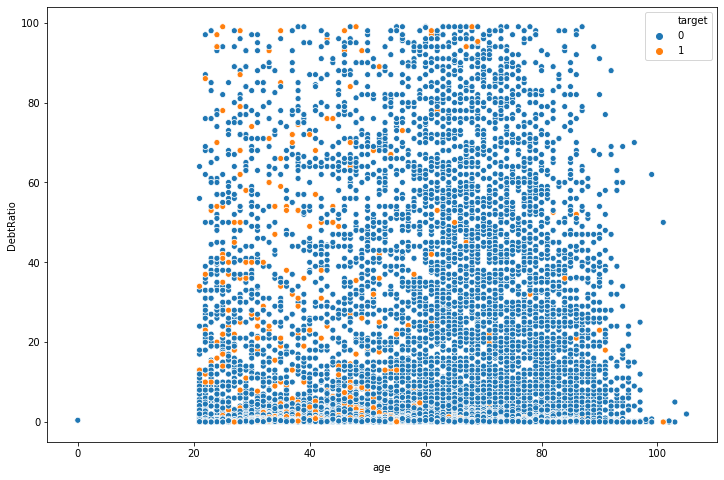

In [92]:
# Hypothesis 1: People with higher age are less likely to default
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='DebtRatio', hue='target', data=train.query("DebtRatio < 100"))
plt.show()

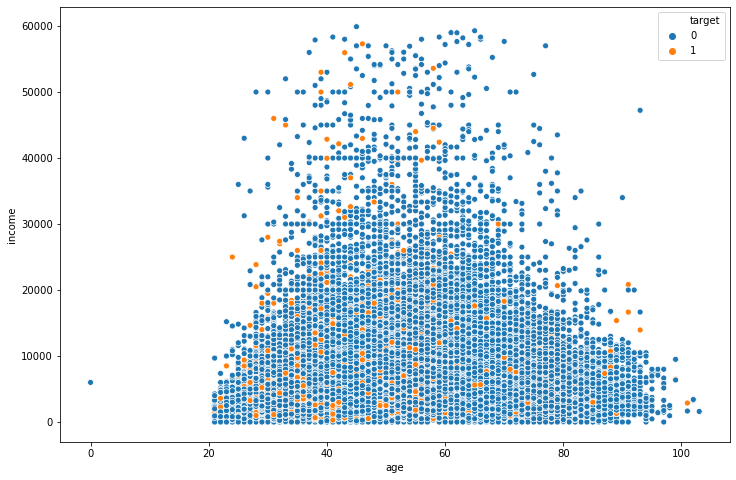

In [93]:
# Hypothesis 2: People with higher age are less likely to default
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='income', hue='target', data=train.query("DebtRatio < 100 & income < 60000"))
plt.show()

### Data Preprocessing

In [171]:
# Based on above analysis, we will impute the null values with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
train["income"] = imputer.fit_transform(train["income"].values.reshape(-1, 1))
test["income"] = imputer.fit_transform(test["income"].values.reshape(-1, 1))

train["n_dependents"] = imputer.fit_transform(train["n_dependents"].values.reshape(-1, 1))
test["n_dependents"] = imputer.fit_transform(test["n_dependents"].values.reshape(-1, 1))

In [94]:
# We will replace age == 0 with the median age
# Minimal impact as there is only 1 row with age == 0
median_age = train.age.median()
train["age"] = train["age"].apply(lambda x: x if x > 0 else median_age)

### Feature Engineering

### Modelling

In [177]:
def get_preds_for_submission(clf, X, test):
    y_preds = clf.predict_proba(X)[:, 1]
    
    preds = pd.DataFrame({
        "Id": test.Id,
        "Probability": y_preds
    })
    
    preds.to_csv("submission.csv", index=False)

In [173]:
# Train test split our training data
X = train.iloc[:, 1:]
y = train.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [174]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [175]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [176]:
roc_auc_score(y_test, y_pred_proba)

0.8410457524646575